# Identify interactions between odor and W_AIR representations in G4 MBONs

In [1]:
%matplotlib inline
from copy import deepcopy
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from aux import Generic
from data import DataLoader, random_chunk_split
from db import make_session, d_models
from lin_fit import fit_h_train_test, calc_r2
from plot import set_font_size, unity_line

import CONFIG as C

In [2]:
TRAIN_LEN = 39  # s
TEST_LEN = 1  # s

WDW = (-3, 1)

METHOD = 'built-in'
PARAMS = {
    'v_fwd': {'model': LinearRegression},
    'odor_binary': {'model': LinearRegression},
    #'control': {'model': LinearRegression},
    'w_air': {'model': lambda: Lasso(alpha=0.5)},
    'air': {'model': LinearRegression},
}

BINS_AIR = np.linspace(-180, 180, 73)
MAX_AIR = 90

Linear models

In [3]:
class ModelVFS(object):
    
    name = 'VFS'
    
    x_names = ['v_fwd']
    y_name = 'g4s'
    normed = True
    
    def __init__(self, trial):
        
        # run odor_binary --> g4s fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'v_fwd': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['v_fwd'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [4]:
class ModelOS(object):
    
    name = 'OS'
    
    x_names = ['odor_binary']
    y_name = 'g4s'
    normed = True
    
    def __init__(self, trial):
        
        # run odor_binary --> g4s fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [5]:
class ModelOR(object):
    
    name = 'OR'
    
    x_names = ['odor_binary']
    y_name = 'g4r'
    normed=True
    
    def __init__(self, trial):
        
        # run odor_binary --> g4r fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [6]:
class ModelOL(object):
    
    name = 'OL'
    
    x_names = ['odor_binary']
    y_name = 'g4l'
    normed = True
    
    def __init__(self, trial):
        
        # run odor_binary --> g4l fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [7]:
class ModelW(object):
    
    name = 'W'
    
    #x_names = ['control']
    x_names = ['w_air']
    y_name = 'g4d'
    
    normed = False
    
    def __init__(self, trial):
        
        # run w_air --> g4d fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            #wdws={'control': WDW},
            wdws={'w_air': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            #params=PARAMS['control'],
            params=PARAMS['w_air'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [8]:
class ModelA(object):
    
    name = 'A'
    
    x_names = ['air']
    y_name = 'g4d'
    
    normed = False
    
    def __init__(self, trial):
        
        # run air --> g4d fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'air': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['air'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [9]:
MODEL_CLASSES = [ModelVFS, ModelOS, ModelOR, ModelOL, ModelW, ModelA]
MODEL_DICT = {model_class.name: model_class for model_class in MODEL_CLASSES}

# Define key functions

In [10]:
def load_trials(region, expt):
    
    # load trials
    session = make_session()
    trials = session.query(d_models.Trial).filter(
        d_models.Trial.region == region, d_models.Trial.expt == expt).all()
    session.close()

    # load data and create a moving average 
    for trial in trials:
        trial.dl = DataLoader(trial, 0, None)

        # nan out air and w_air for times when air is past threshold
        mask = np.abs(trial.dl.air) < MAX_AIR

        air, w_air = trial.dl.air, trial.dl.w_air

        air[~mask] = np.nan
        w_air[~mask] = np.nan

        trial.dl.data['AIR'] = air
        trial.dl.data['W_AIR'] = w_air
        
    return trials

In [11]:
def plot_air(trials):
    
    airs = np.concatenate([trial.dl.air for trial in trials])

    fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
    ax.hist(airs[~np.isnan(airs)], bins=BINS_AIR)

    ax.set_xlabel('Air tube position (deg)')
    ax.set_ylabel('Counts')

    set_font_size(ax, 16)

In [12]:
def fit_models(trials):

    models = {}

    for model_class in MODEL_CLASSES:

        models_ = {trial.name: model_class(trial) for trial in trials}
        models[model_class.name] = models_
        
    return models

In [13]:
def plot_y_vs_y_hat(trials, models):
    
    ax_h = 3
    
    ax_grid = (len(trials), len(models))

    fig_size = (20, ax_h*ax_grid[0])

    fig, axs = plt.subplots(*ax_grid, figsize=fig_size, tight_layout=True)

    r2s_train = {model_class.name: [] for model_class in MODEL_CLASSES}

    for trial, ax_row in zip(trials, axs):
        for model_class, ax in zip(MODEL_CLASSES, ax_row):

            model = models[model_class.name][trial.name]

            y = model.rslt.y
            y_hat_train = model.rslt.y_hat_train
            y_hat_test = model.rslt.y_hat_test
            r2_train = model.rslt.r2_train

            ax.scatter(y_hat_train, y, lw=0, c='gray', s=1)
            ax.scatter(y_hat_test, y, lw=0, c='k', s=8)

            unity_line(ax, *ax.get_xlim(), ls='--', zorder=-1)

            ax.grid()
            
            if np.abs(model.rslt.r2_train) > 1:
                r2_train = np.nan
            else:
                r2_train = model.rslt.r2_train
                
            ax.set_title('{0}\n({1})\nR2 = {2:1.4f}'.format(trial.name, model.name, r2_train))

            r2s_train[model_class.name].append(r2_train)

    for ax in axs.flatten():
        ax.set_xlabel('y_hat')
        ax.set_ylabel('y')
        set_font_size(ax, 16)
        
    return r2s_train

In [14]:
def plot_r2_scatters(r2s_train):
    
    fig, axs = plt.subplots(1, len(R2_SCATTERS), figsize=(15, 5), tight_layout=True, squeeze=False)
    axs = axs[0]

    for r2_scatter, ax in zip(R2_SCATTERS, axs):
        r2_x = r2s_train[r2_scatter[0]]
        r2_y = r2s_train[r2_scatter[1]]

        x_label = 'R2({})'.format(r2_scatter[2])
        y_label = 'R2({})'.format(r2_scatter[3])

        ax.scatter(r2_x, r2_y, c='k', lw=0)

        ax.set_xlim(-0.2, 0.8)
        ax.set_ylim(-0.2, 0.8)

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        set_font_size(ax, 16)

In [15]:
def plot_r2s_bar(trials, models):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

    r2_mdns = []
    r2_stds = []

    for model_class in MODEL_CLASSES:

        r2s = []

        for trial in trials:
            model = models[model_class.name][trial.name]

            r2 = model.rslt.r2_train

            r2s.append(r2)

        r2_mdns.append(np.nanmedian(r2s))
        r2_stds.append(np.nanstd(r2s))

    x_bar = np.arange(len(r2_mdns))
    x_ticks = x_bar
    x_tick_labels = [model_class.name for model_class in MODEL_CLASSES]

    ax.bar(x_bar, r2_mdns, yerr=r2_stds, align='center')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

    ax.axhline(0, color='gray', ls='--')
    ax.axvline(3.5, color='r', lw=2)

    ax.set_ylim(0, 1)
    
    ax.grid()

    ax.set_xlabel('Model Class')
    ax.set_ylabel('R2')

    set_font_size(ax, 16)

In [16]:
def plot_filters(trials, models):
    
    ax_h = 3.5
    
    ax_grid = (len(trials) + 1, len(models))
    
    fig_size = (20, ax_h*ax_grid[0])

    y_lims = {
        'VFS': (-0.2, 0.2),
        'OS': (-0.2, 0.2),
        'OR': (-0.2, 0.2),
        'OL': (-0.2, 0.2),
        'W': (-0.004, 0.0015),
        'A': (-0.01, 0.01),
    }

    fig, axs = plt.subplots(*ax_grid, figsize=fig_size, tight_layout=True)

    labels = [mc.name for mc in MODEL_CLASSES]

    t_hs = {label: [] for label in labels}
    hs = {label: [] for label in labels}
    icpts = {label: [] for label in labels}

    # plot individual trial filters
    for trial, ax_row in zip(trials, axs):
        for ctr, ax in enumerate(ax_row):

            label = labels[ctr]
            model = models[label][trial.name]
            t_h = model.rslt.t_hs[model.rslt.x_names[0]]
            h = model.rslt.hs[model.rslt.x_names[0]]
            icpt = model.rslt.icpt

            ax.plot(t_h, h, lw=2, c='k')
            ax.axhline(0, c='r', lw=2)
            ax.axvline(0, c='r', lw=2)
            
            if np.abs(model.rslt.r2_train) > 1:
                r2_train = np.nan
            else:
                r2_train = model.rslt.r2_train
                
            ax.set_title('{0}\n({1})\nR2 = {2:1.4f}'.format(trial.name, label, r2_train))

            t_hs[label].append(t_h)
            hs[label].append(h)
            icpts[label].append(icpt)

    # plot mean filters
    t_hs_mdn = {label: np.nanmedian(t_hs[label], 0) for label in labels}
    hs_mdn = {label: np.nanmedian(hs[label], 0) for label in labels}
    icpts_mdn = {label: np.nanmedian(icpts[label], 0) for label in labels}

    for label, ax in zip(labels, axs[-1, :]):

        ax.axhline(0, c='r', lw=2)
        ax.axvline(0, c='r', lw=2)

        ax.plot(t_hs_mdn[label], np.array(hs[label]).T, lw=0.5, color='gray')
        ax.plot(t_hs_mdn[label], hs_mdn[label], lw=3, color='k')

        ax.set_ylim(y_lims[label])

        ax.set_title(label)

    for ax in axs.flatten():

        ax.grid()

        ax.set_xlabel('t (s)')
        ax.set_ylabel('h')

        set_font_size(ax, 16)
        
    return fig, hs_mdn, icpts_mdn

# Plot truth vs predicted G4X for each trial/model

In [17]:
R2_SCATTERS = [
    ('VFS', 'OS', 'v_fwd->g4s', 'odor->g4s'),
    ('OS', 'W', 'odor->g4s', 'w_air->g4d'),
    ('VFS', 'W', 'v_fwd->g4s', 'w_air->g4d'),
]

### White noise trials

In [18]:
trials = load_trials(region='mbon', expt='white_odor_fluct')

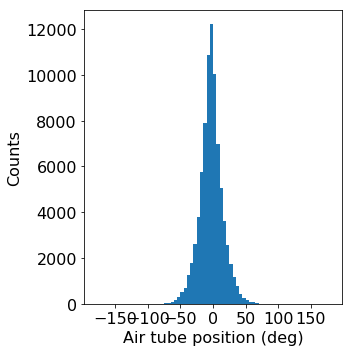

In [19]:
plot_air(trials)

In [20]:
models = fit_models(trials)

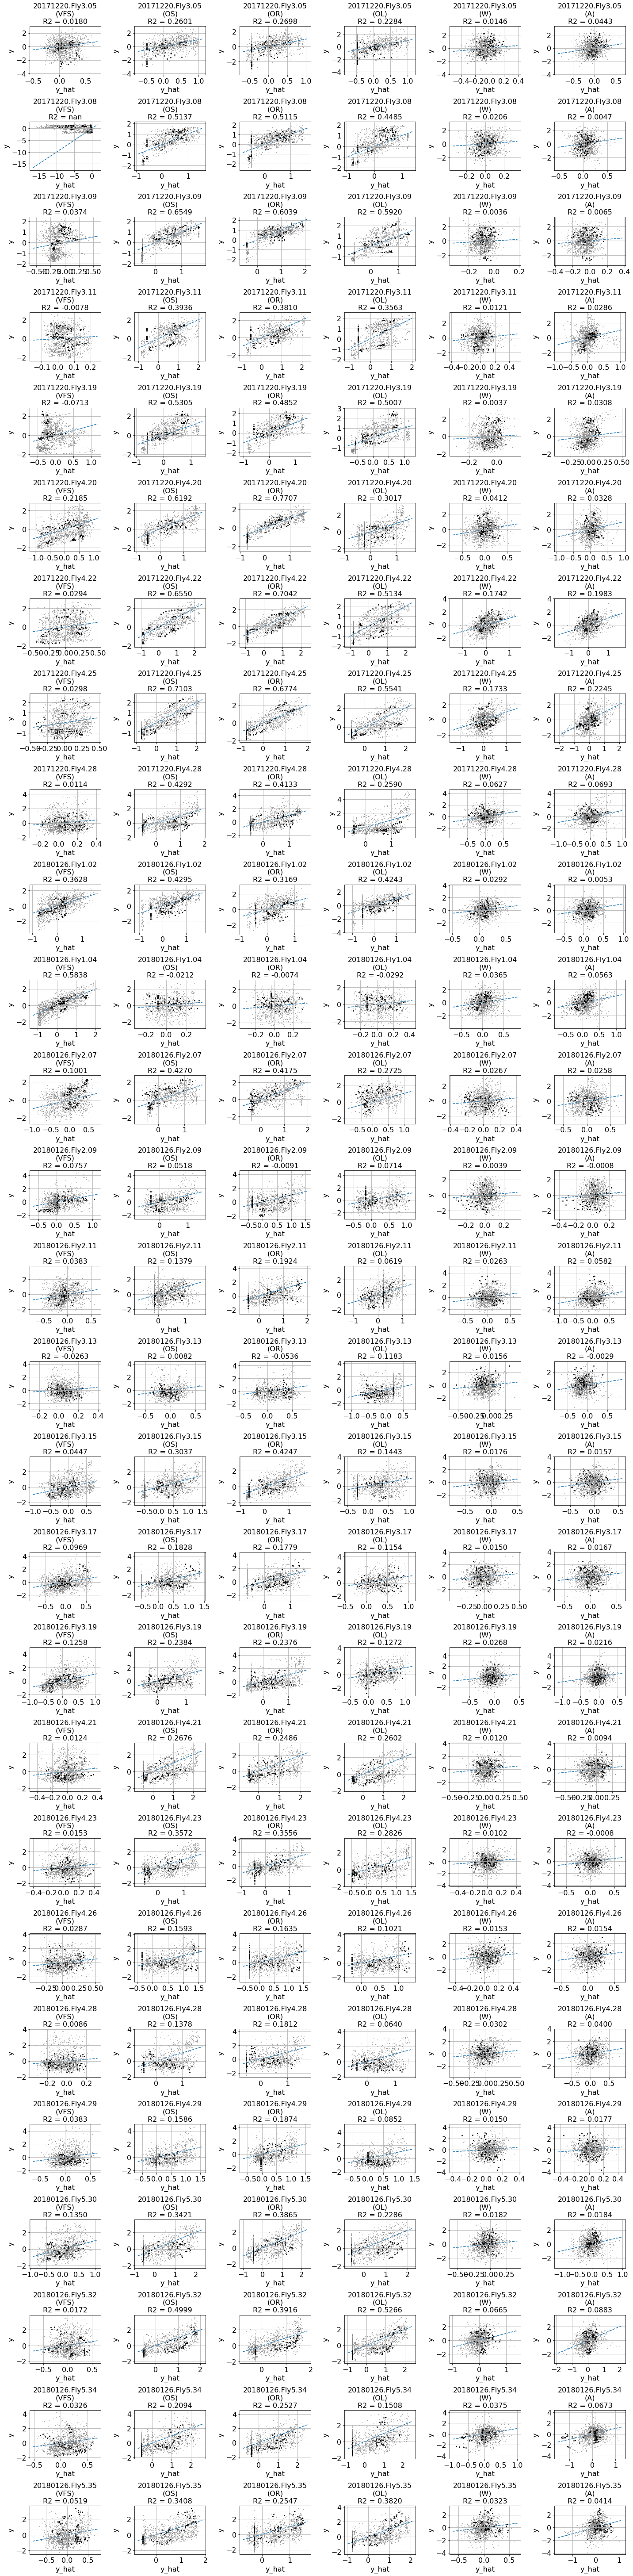

In [21]:
r2s_train = plot_y_vs_y_hat(trials, models)

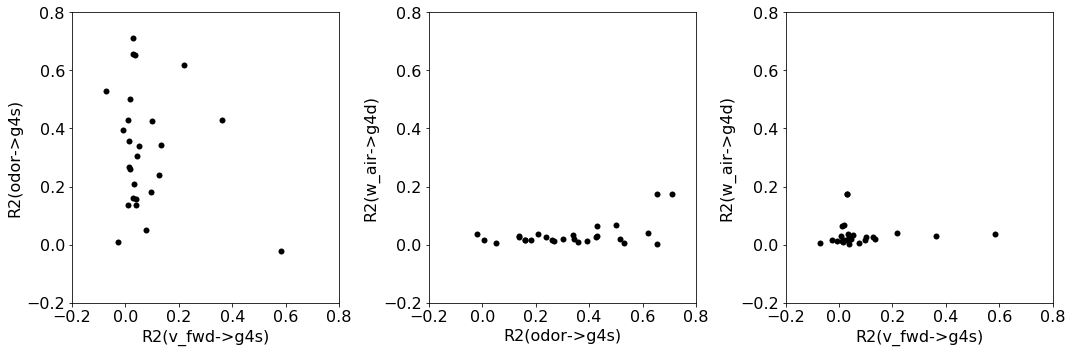

In [22]:
plot_r2_scatters(r2s_train)

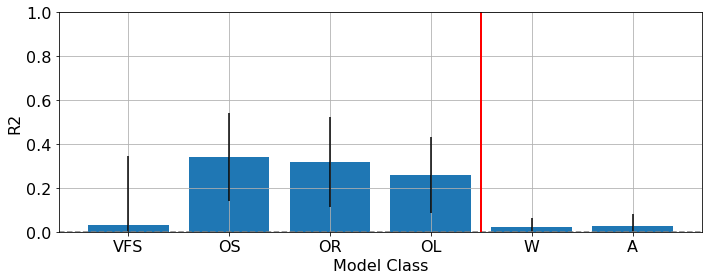

In [23]:
plot_r2s_bar(trials, models)

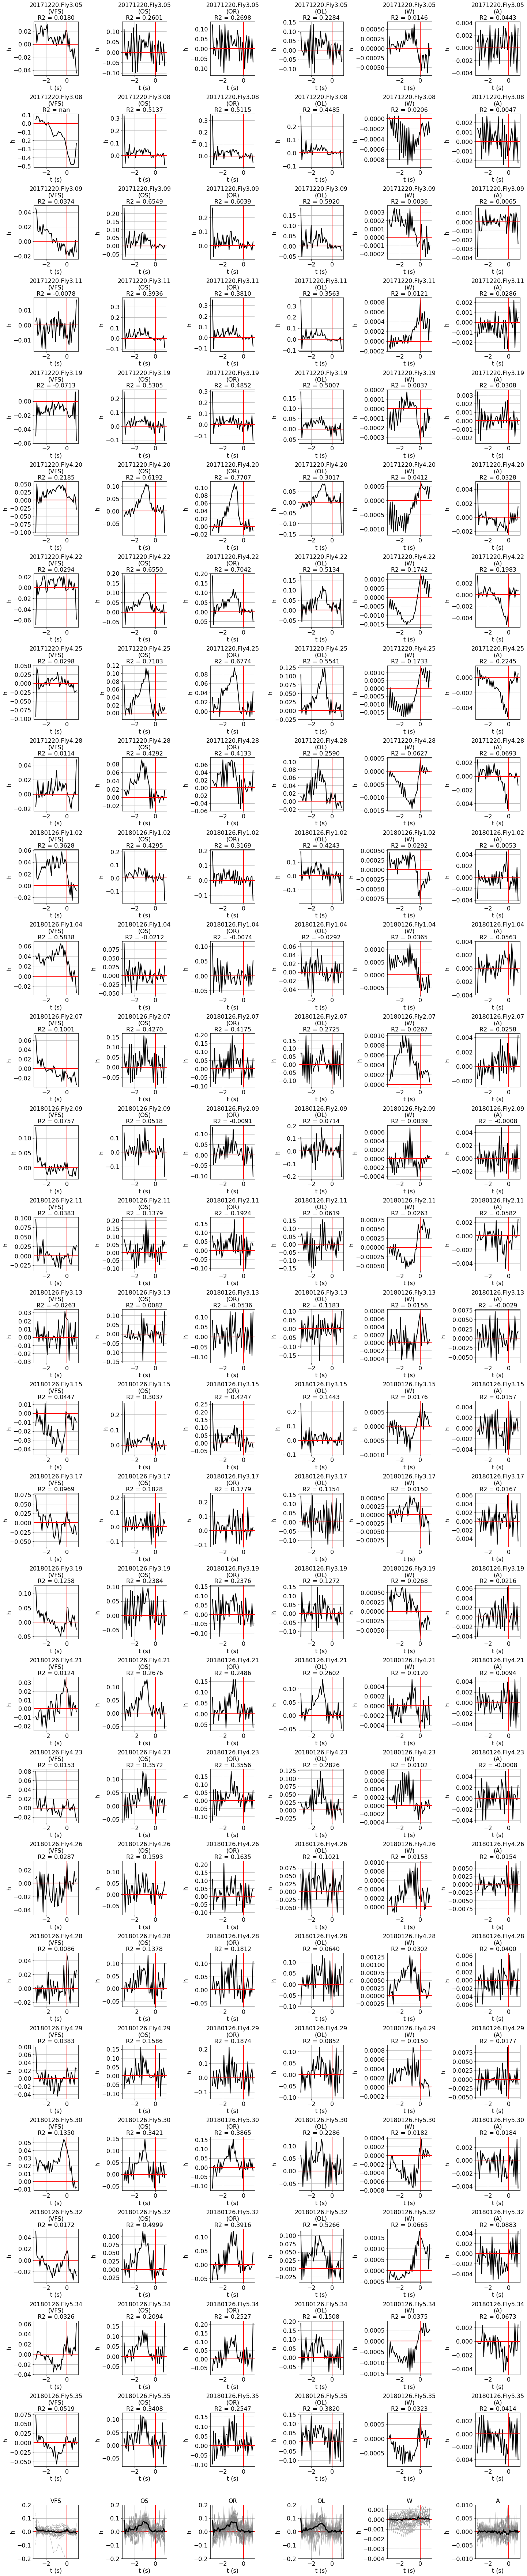

In [24]:
fig_w, hs_mdn_w, icpts_mdn_w = plot_filters(trials, models)

In [25]:
fig_w.savefig('temp_w_mbon.png', dpi=300)

### Closed loop trials

In [26]:
trials = load_trials(region='mbon', expt='closed_periodic_pulses')

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


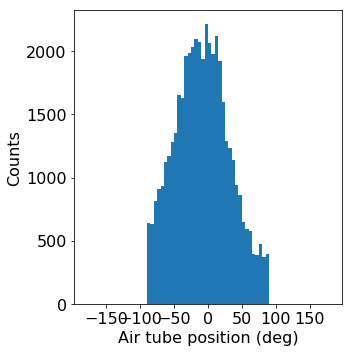

In [27]:
plot_air(trials)

In [28]:
models = fit_models(trials)

Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.


/Users/rkp/Dropbox/Repositories/mushroom_mushroom/data.py:750: RuntimeWarning: invalid value encountered in true_divide
  data_normed = col_zeroed / np.nanstd(col_zeroed)
/Users/rkp/Dropbox/Repositories/mushroom_mushroom/lin_fit.py:154: RuntimeWarning: Mean of empty slice
  hs_mean = {x_name: np.nanmean(hs_, 0) for x_name, hs_ in hs.items()}
/Users/rkp/Dropbox/Repositories/mushroom_mushroom/lin_fit.py:155: RuntimeWarning: Mean of empty slice
  icpt_mean = np.nanmean(icpts, 0)


Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.


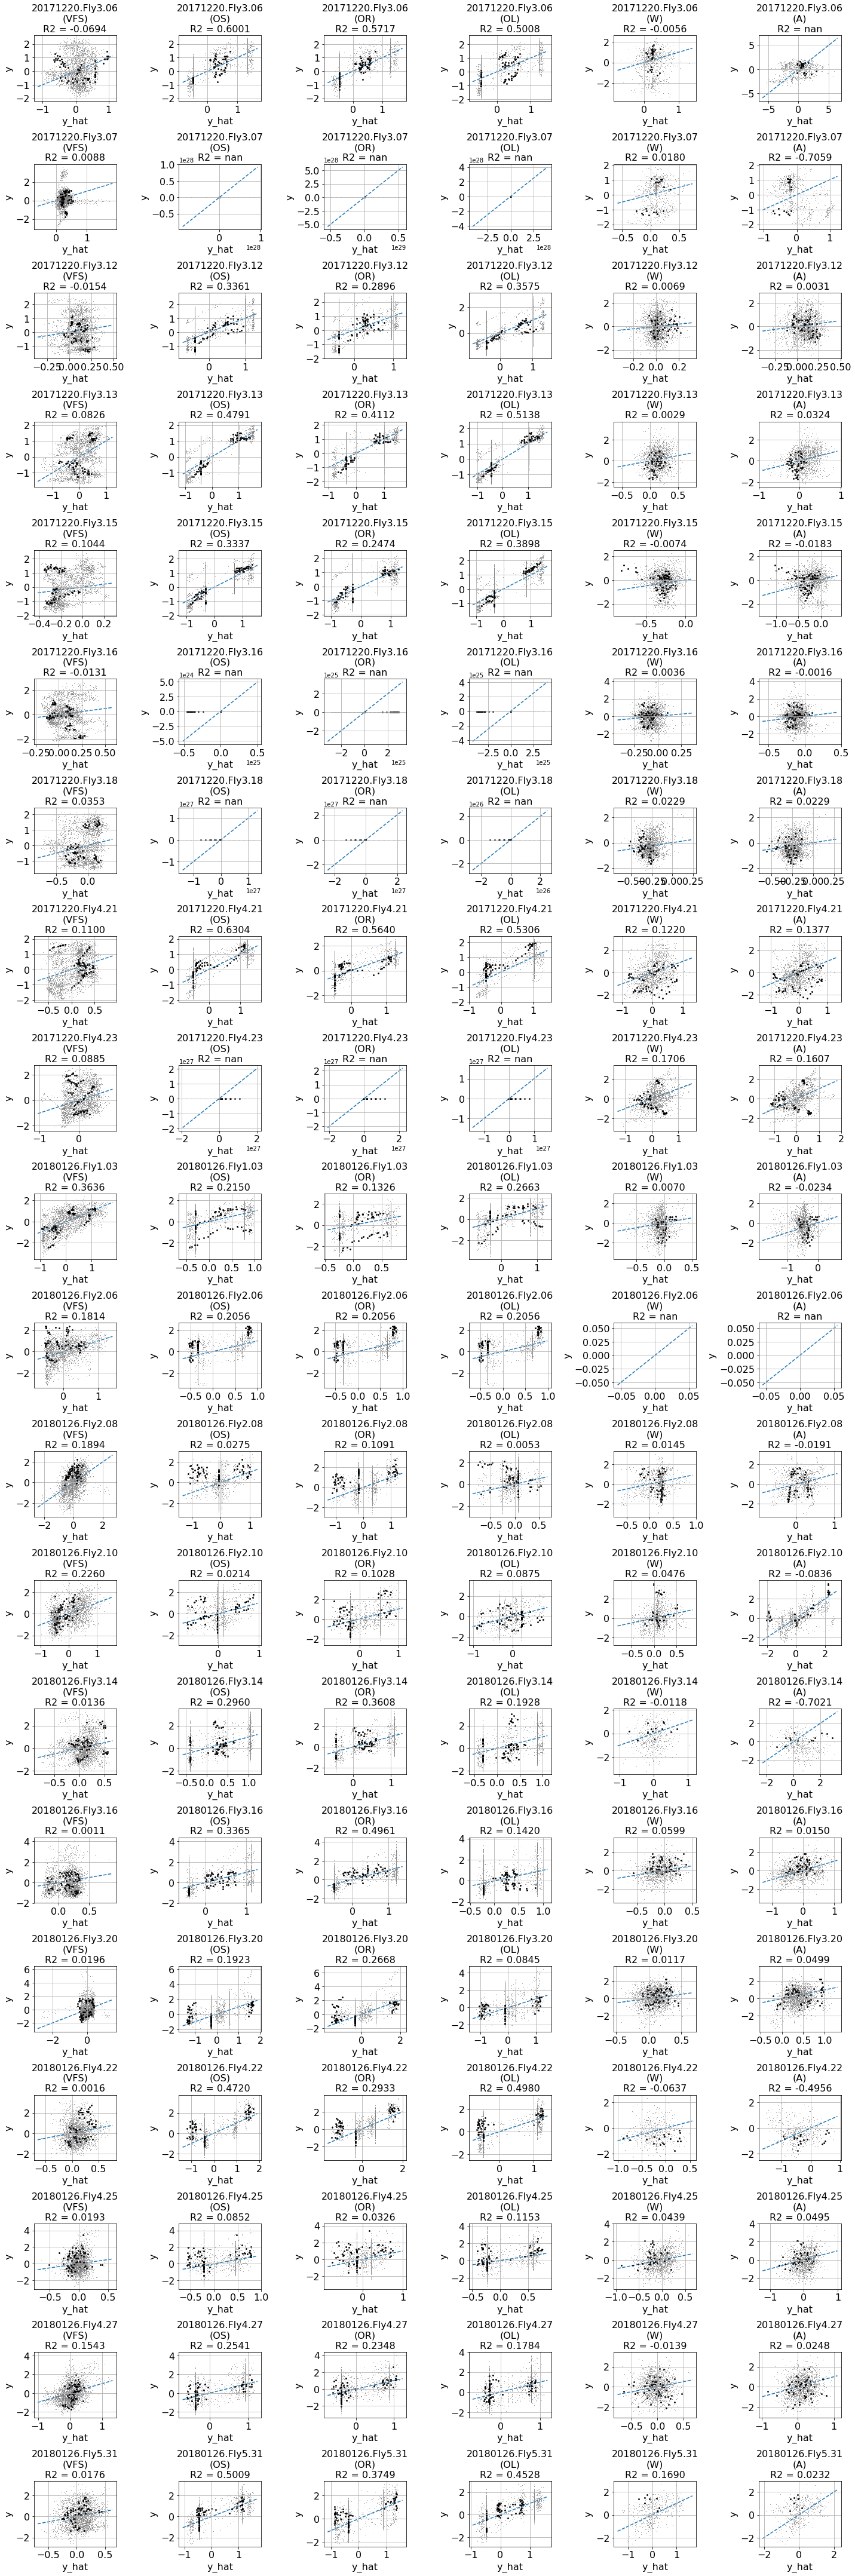

In [29]:
r2s_train = plot_y_vs_y_hat(trials, models)

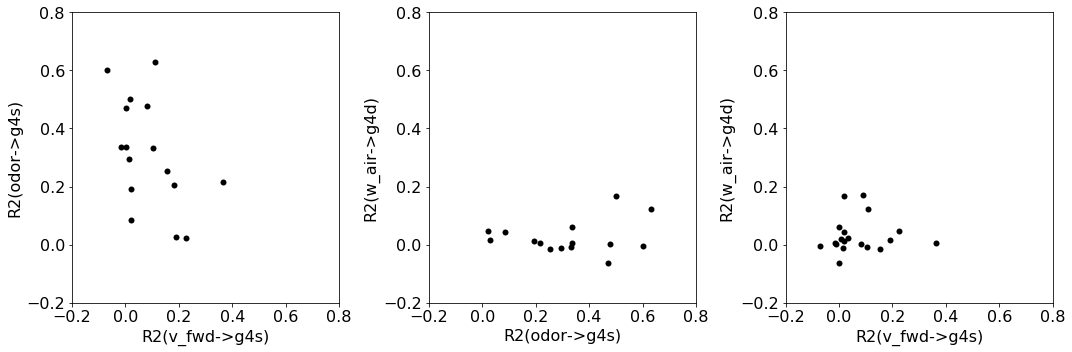

In [30]:
plot_r2_scatters(r2s_train)

In [31]:
plot_r2s_bar(trials, models)

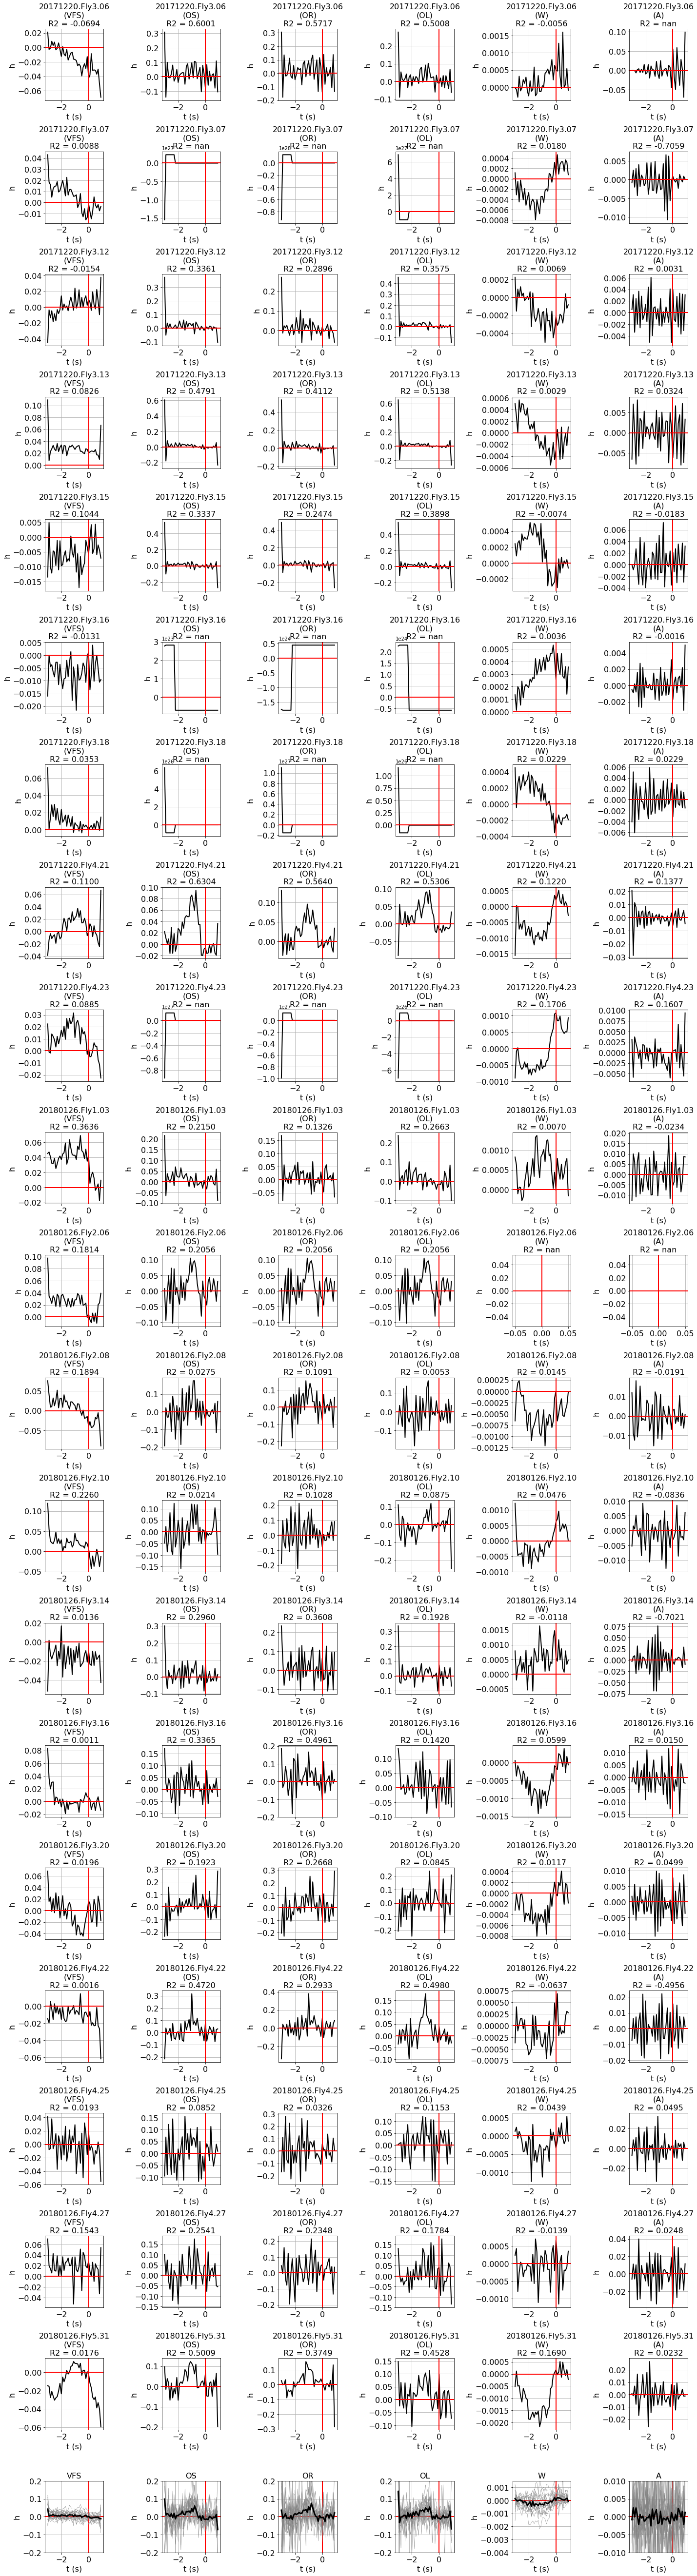

In [32]:
fig_c, hs_mdn_c, icpts_mdn_c = plot_filters(trials, models)

In [33]:
fig_c.savefig('temp_c_mbon.png', dpi=300)

# Run cross-predictions

I.e. predict C trials with filters fit on W trials and W trials with filters fit on C trials.

In [34]:
hs_mdn = {
    'white_odor_fluct': hs_mdn_w,
    'closed_periodic_pulses': hs_mdn_c,
}

icpts_mdn = {
    'white_odor_fluct': icpts_mdn_w,
    'closed_periodic_pulses': icpts_mdn_c,
}

In [35]:
from data import norm_by_col
from lin_fit import make_extended_predictor_matrix, calc_r2

def predict_trials_from_h(trials, x_name, y_name, h, icpt, wdw, normed):
    
    wdw_d = (int(round(wdw[0] / C.DT)), int(round(wdw[1] / C.DT)))
    
    r2s = []
    
    for trial in trials:
        x = getattr(trial.dl, x_name)
        y = getattr(trial.dl, y_name)
        
        if normed:
            x = norm_by_col(x)
            y = norm_by_col(y)
        
        x_xtd = make_extended_predictor_matrix(
            vs={x_name: x},
            windows={x_name: wdw_d},
            order=[x_name])
        
        y_hat = x_xtd.dot(h) + icpt
    
        r2s.append(calc_r2(y, y_hat))
    
    return r2s

In [36]:
COLS = ['FILT', 'FIT ON', 'TESTED ON', 'MED R2', 'STD R2', 'MAX R2']
FILTS = ['VFS', 'OS', 'W']
TITLES = ['V_FWD --> G4S', 'ODOR --> G4S', 'W_AIR --> G4D']

df = pd.DataFrame(columns=COLS)

fig, axs = plt.subplots(1, len(FILTS), figsize=(15, 4), tight_layout=True, squeeze=False)
axs = axs[0]

row = 0

for filt, title, ax in zip(FILTS, TITLES, axs):
    
    x_ofst = 0
    x_tick_labels = []
    
    for fit_on in ['white_odor_fluct', 'closed_periodic_pulses']:
        for tested_on in ['white_odor_fluct', 'closed_periodic_pulses']:
            
            r2s = predict_trials_from_h(
                trials=load_trials('mbon', tested_on),
                x_name=MODEL_DICT[filt].x_names[0],
                y_name=MODEL_DICT[filt].y_name,
                h=hs_mdn[fit_on][filt],
                icpt=icpts_mdn[fit_on][filt],
                wdw=WDW,
                normed=MODEL_DICT[filt].normed)
            
            df.loc[row] = {
                'FILT': filt,
                'FIT ON': fit_on,
                'TESTED ON': tested_on,
                'MED R2': np.nanmedian(r2s),
                'STD R2': np.nanstd(r2s),
                'MAX R2': np.nanmax(r2s),
            }
            
            xs = x_ofst * np.ones(len(r2s)) + np.random.normal(0, 0.05, len(r2s))
            
            ax.scatter(xs, r2s, lw=0, c='k', s=20)
            
            ax.plot([x_ofst-0.2, x_ofst+0.2], 2*[np.nanmedian(r2s)], color='r', lw=2)
            
            x_tick_labels.append('({}, {})'.format(fit_on[0].upper(), tested_on[0].upper()))
            
            x_ofst += 1
            row += 1
            
    ax.set_xticks(range(x_ofst))
    ax.set_xticklabels(x_tick_labels)
    
    ax.set_xlabel('(FIT ON, TESTED ON)')
    ax.set_ylabel('R2')
    
    ax.set_title(title)
    
for ax in axs:
    set_font_size(ax, 16)

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/rkp/Dropbox/Repositories/mushroom_mushroom/data.py:750: RuntimeWarning: invalid value encountered in true_divide
  data_normed = col_zeroed / np.nanstd(col_zeroed)


In [37]:
df

FILT                  FIT ON               TESTED ON    MED R2    STD R2  \
0   VFS        white_odor_fluct        white_odor_fluct  0.005877  0.021192   
1   VFS        white_odor_fluct  closed_periodic_pulses  0.006199  0.023697   
2   VFS  closed_periodic_pulses        white_odor_fluct  0.001284  0.044299   
3   VFS  closed_periodic_pulses  closed_periodic_pulses  0.004567  0.049910   
4    OS        white_odor_fluct        white_odor_fluct  0.287820  0.314627   
5    OS        white_odor_fluct  closed_periodic_pulses  0.155578  0.510724   
6    OS  closed_periodic_pulses        white_odor_fluct  0.222846  0.155191   
7    OS  closed_periodic_pulses  closed_periodic_pulses  0.279450  0.242851   
8     W        white_odor_fluct        white_odor_fluct  0.000068  0.003624   
9     W        white_odor_fluct  closed_periodic_pulses  0.000959  0.005222   
10    W  closed_periodic_pulses        white_odor_fluct -0.010547  0.022307   
11    W  closed_periodic_pulses  closed_periodic_pulses  0.004203  0.030997   

      MAX R2  
0   0.058731  
1   0.061050  
2   0.132558  
3   0.111593  
4   0.625781  
5   0.596781  
6   0.399001  
7   0.455478  
8   0.008881  
9   0.013949  
10  0.055730  
11  0.078974